In [ ]:
# generate structures using leruli
# choose a fancy basis set
# optimize with pbe0
# generate fragments
# calculate frag without optimization
# with optimization

# collect energies into one file
# energy energy_frag energy_ BDE BDE_relaxed

In [ ]:
import ase.io as aio
from ase.units import Bohr
from ase import Atoms
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

from pyscf import gto, dft, scf

# geometric
from pyscf.geomopt.geometric_solver import optimize

from ase.visualize import view

## Look at structures

In [ ]:
comps = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']

for c in comps:
    #c = 'FF'
    p = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_single/{c}_opt.xyz'
    atoms = aio.read(p)
    p2 = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_single/{c}.xyz'
    atoms2 = aio.read(p2)
    print(atoms.get_distance(0,1)-atoms2.get_distance(0,1))
#view(atoms, viewer='x3d')

### Fragments

In [ ]:
# for c in ['CC', 'NN', 'OO', 'FF']:
#     #c = 'FF'
#     p = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/fragments/{c}_opt.xyz'
#     atoms = aio.read(p)
#     p2 = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/fragments/{c}.xyz'
#     atoms2 = aio.read(p2)
#     print(atoms.get_distance(0,1)-atoms2.get_distance(0,1))
c = 'FF' 
p = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/fragments/{c}_opt.xyz'
# p = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/fragments/{c}.xyz'

atoms = aio.read(p)
#print(atoms.get_distance(0,1))
view(atoms, viewer='x3d')

# Prepare calculations

In [ ]:
# comps = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']
c = 'CC' #sys.argv[1]
atoms = aio.read(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_single/{c}.xyz')

pyscf_atoms = uqm.ase2pyscf(atoms)
basis = 'def2-tzvp'
mol = gto.Mole()
mol.atom = pyscf_atoms
mol.basis = basis
mol.build()

mf = dft.RKS(mol)
mf.xc = 'pbe0'
mol_eq = optimize(mf, maxsteps=100)

mf = dft.RKS(mol)
mf.kernel()

new_pos = mol_eq.atom_coords()*Bohr

atoms.set_positions(new_pos)
aio.write(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_single/{c}_opt.xyz', atoms)

with open(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_single/{c}_energy', 'w') as f:
    f.write(str(mf.e_tot)+'\n')

# fragment calculations

In [ ]:
comps = ['CC','NN', 'OO', 'FF']
for smiles in comps:
    structure = aio.read(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_single/{smiles}_opt.xyz')
    if structure.get_chemical_symbols()[0] == 'C':
#         structure.set_distance(1,0, dCO, indices=[0, 2, 3, 4], fix = 0)
        indices=[0, 2, 3, 4]
    elif structure.get_chemical_symbols()[0] == 'N':
#         structure.set_distance(0,1, dCO, indices=[0, 2, 3])
        indices=[0, 2, 3]
    elif structure.get_chemical_symbols()[0] == 'O':
#         structure.set_distance(0,1, dCO, indices=[0, 2])
        indices=[0, 2]
    elif structure.get_chemical_symbols()[0] == 'F':
#         structure.set_distance(0,1, dCO)
        indices=[0]
        
    frag = Atoms(numbers = structure.get_atomic_numbers()[indices], positions=structure.get_positions()[indices])
    aio.write(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/fragments/{smiles}.xyz', frag)


# collect data

In [ ]:
import glob
from matplotlib import pyplot as plt
import numpy as np
import ase.io as aio
from pyscf import gto

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

In [ ]:
# total energy of diatomics
energies_diatomics = dict()
efiles = glob.glob('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_single/*_energy')
for file in efiles:
    with open(file, 'r') as f:
        k = file.split('/')[-1].split('_')[0]
        energies_diatomics[k] = float(f.readline().strip('\n'))

# total energy of relaxed fragments
energies_frags = dict()
efiles = glob.glob('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/fragments/*_energy_relaxed')
for file in efiles:
    with open(file, 'r') as f:
        k = file.split('/')[-1].split('_')[0][0]
        energies_frags[k] = float(f.readline().strip('\n'))

# bfe
bfe = dict()
for k in energies_diatomics.keys():
    bfe[k] = energies_diatomics[k] - (energies_frags[k[0]]+energies_frags[k[1]])

# nuc repulsion for fixed distance and only contribution of heteroatoms
structures = glob.glob("/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_single/*_opt.xyz")
e_nuc = dict()
from ase.units import Bohr
d = 1.421151094407886/Bohr

for s in structures:
    mol = aio.read(s)
    k = s.split('/')[-1].split('_')[0]
    
    fixed = mol.get_atomic_numbers()[0]*mol.get_atomic_numbers()[1]/d
    relaxed = mol.get_atomic_numbers()[0]*mol.get_atomic_numbers()[1]/(mol.get_distance(0, 1)/Bohr)
    e_nuc[k] = [fixed]
# bfe, bfe_el, bfe_nuc 
energies = dict()
for k in bfe.keys():
    bfe_el = bfe[k] - e_nuc[k][0]
    #bfe_elr = bfe[k] - e_nuc[k][1]
    
    energies[k] = [bfe[k], bfe_el, e_nuc[k][0]]
    
# save data
path = '/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_dict'
uqm.save_obj(energies, path)

comps = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']
energies_ordered = []
for c in comps:
    energies_ordered.append(energies[c])
energies_ordered = np.array(energies_ordered)
np.savetxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies.txt', energies_ordered)

In [ ]:
energies

In [ ]:
energies_ordered

In [ ]:
comps = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']
bde_ordered = []
for c in comps:
    bde_ordered.append(-energies[c][0]*2600)

In [ ]:
ref_bde = np.array([359.2, 337.7, 370.2, 452, 259.6, 253.5, 283.6, 195.2, 194.9, 151.7])

plt.plot(comps, bde_ordered, '-o')
plt.plot(comps, ref_bde, '-o')

# Double bonds

In [ ]:
from ase.visualize import view
import ase.io as aio

In [ ]:
comps = ['dCC','dCN', 'dCO', 'dNN', 'dNO', 'dOO']
for c in comps:
    mol = aio.read(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_double/{c}_opt.xyz')
    view(mol)

In [ ]:
comps = ['dCC','dCN', 'dCO', 'dNN', 'dNO', 'dOO']
for c in comps:
    with open(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_double/{c}_energy') as f:
        print(c, f.readline().strip('\n'))

In [ ]:
# mean distance between heavy atoms
# needed for nuclear repulsion calculation

bond_type = 'double'

structures = glob.glob(f"/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_{bond_type}/*_opt.xyz")
from ase.units import Bohr
dist = []
for s in structures:
    mol = aio.read(s)
    dist.append(mol.get_distance(0, 1))
dist = np.array(dist)
mean_dist = dist.mean()


In [ ]:
bfe

In [ ]:
bond_type = 'double'
# total energy of diatomics
energies_diatomics = dict()
efiles = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_{bond_type}/*_energy')
for file in efiles:
    with open(file, 'r') as f:
        k = file.split('/')[-1].split('_')[0]
        energies_diatomics[k] = float(f.readline().strip('\n'))

# total energy of relaxed fragments
energies_frags = dict()
efiles = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/fragments_{bond_type}/*_energy_relaxed')
for file in efiles:
    with open(file, 'r') as f:
        k = file.split('/')[-1].split('_')[0][0:2]
        energies_frags[k] = float(f.readline().strip('\n'))

# bfe
bfe = dict()
for k in energies_diatomics.keys():
    bfe[k] = energies_diatomics[k] - (energies_frags[k[0:2]]+energies_frags['d'+k[2]])

# nuc repulsion for fixed distance and only contribution of heteroatoms
structures = glob.glob(f"/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/diatomics_{bond_type}/*_opt.xyz")
e_nuc = dict()
from ase.units import Bohr
d = mean_dist/Bohr

for s in structures:
    mol = aio.read(s)
    k = s.split('/')[-1].split('_')[0]
    
    fixed = mol.get_atomic_numbers()[0]*mol.get_atomic_numbers()[1]/d
    relaxed = mol.get_atomic_numbers()[0]*mol.get_atomic_numbers()[1]/(mol.get_distance(0, 1)/Bohr)
    e_nuc[k] = [fixed]
# bfe, bfe_el, bfe_nuc 
energies = dict()
for k in bfe.keys():
    bfe_el = bfe[k] - e_nuc[k][0]
    #bfe_elr = bfe[k] - e_nuc[k][1]
    
    energies[k] = [bfe[k], bfe_el, e_nuc[k][0]]
    
# save data
path = '/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_double_dict'
uqm.save_obj(energies, path)

comps = ['dCC','dCN','dCO','dNN','dNO','dOO']
energies_ordered = []
for c in comps:
    energies_ordered.append(energies[c])
energies_ordered = np.array(energies_ordered)
np.savetxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_double_singlet.txt', energies_ordered)

# third/fourth row

In [1]:
import glob
import ase.io as aio
from ase.visualize import view
import numpy as np

import re
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

In [2]:
# elements = ['[SiH3]', 'P', 'S', 'Cl']

elements = ['[GeH3]', '[AsH2]', '[SeH]', 'Br']


smiles = []
for i in range(len(elements)):
    for j in range(i, len(elements)):
        smiles.append(elements[i]+elements[j])
with open('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/diatomics_single/smiles', 'w') as f:
    for e in smiles:
        f.write(e+'\n')

In [ ]:
paths = glob.glob('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/diatomics_single/*.xyz')
for p in paths:
    view(aio.read(p))

### collect data

In [12]:
# mean distance between heavy atoms
# needed for nuclear repulsion calculation

row = 'row_4'
system = 'diatomics'
bond_type = 'single'

structures = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/{system}_{bond_type}/*_d2.xyz')
from ase.units import Bohr
dist = []
for s in structures:
    mol = aio.read(s)
    dist.append(mol.get_distance(0, 1))
dist = np.array(dist)
mean_dist = dist.mean()
print(mean_dist)
print(dist.std())

1.4209260468449116
2.8562629038867276e-09


In [13]:
mean_dist

1.4209260468449116

In [10]:
energies_diatomics

{'[GeH3][SeH]': -4479.517384608777,
 '[SeH]Br': -4974.712661479157,
 '[AsH2][AsH2]': -4472.613351241432,
 '[SeH][SeH]': -4802.766304718052,
 '[AsH2]Br': -4809.688472274245,
 '[GeH3]Br': -4651.5284174848075,
 '[GeH3][AsH2]': -4314.432478937179,
 '[GeH3][GeH3]': -4156.231445105399,
 '[AsH2][SeH]': -4637.697878035026,
 'BrBr': -5146.677996650496}

In [9]:
bfe

{'[GeH3][SeH]': 0.7887252104201252,
 '[SeH]Br': 0.9246257048953339,
 '[AsH2][AsH2]': 0.9066537273711219,
 '[SeH][SeH]': 0.8880106086535307,
 '[AsH2]Br': 0.8816597308550627,
 '[GeH3]Br': 0.7606641917354864,
 '[GeH3][AsH2]': 0.8064757030660985,
 '[GeH3][GeH3]': 0.7264592062892916,
 '[AsH2][SeH]': 0.8892821127274146,
 'BrBr': 0.9422623909013055}

In [23]:
row = 'row_3'
system = 'diatomics'
bond_type = 'single'

# if row == 'row_3':
#     frag_types = ['Si', 'P', 'S', 'Cl']
# elif row == 'row_4':
#     frag_types = ['[GeH3]', '[AsH2]', '[SeH]', 'Br']

# total energy of diatomics
energies_diatomics = dict()
efiles = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/{system}_{bond_type}/*d2_energy')
for file in efiles:
    with open(file, 'r') as f:
        k = file.split('/')[-1].split('_')[0]
        energies_diatomics[k] = float(f.readline().strip('\n'))

# total energy of relaxed fragments
# row = 'row_3'
system = 'fragments'
# bond_type = 'single'
                   
energies_frags = dict()
efiles = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/{system}_{bond_type}/*_energy_relaxed')
for file in efiles:
    with open(file, 'r') as f:
        smiles = file.split('/')[-1].split('_')[0]
        frags = uqm.fragmentize_smiles(smiles)
        frag_name = frags[0]
#         if len(re.findall(r"\[.*?\]", smiles)) > 0:
#             frag_name = re.findall(r"\[.*?\]", smiles)[0]
#         else:
#             frag_name = re.sub( r"([A-Z])", r" \1", smiles).split()[0]

        energies_frags[frag_name] = float(f.readline().strip('\n'))

# bfe
bfe = dict()
for smiles in energies_diatomics.keys():
#     if len(re.findall(r"\[.*?\]", smiles)) > 0:
#         frags = re.findall(r"\[.*?\]", smiles)
#     else:
#         frags = re.sub( r"([A-Z])", r" \1", smiles).split()
    frags = uqm.fragmentize_smiles(smiles)
    assert len(frags) == 2
    
    bfe[smiles] = energies_diatomics[smiles] - (energies_frags[frags[0]]+energies_frags[frags[1]])

# nuc repulsion for fixed distance and only contribution of heteroatoms
structures = glob.glob(f"/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/diatomics_{bond_type}/*_d2.xyz")
e_nuc = dict()
from ase.units import Bohr
d = mean_dist/Bohr

for s in structures:
    mol = aio.read(s)
    k = s.split('/')[-1].split('_')[0]
    
    fixed = mol.get_atomic_numbers()[0]*mol.get_atomic_numbers()[1]/d
    relaxed = mol.get_atomic_numbers()[0]*mol.get_atomic_numbers()[1]/(mol.get_distance(0, 1)/Bohr)
    e_nuc[k] = [fixed]
# bfe, bfe_el, bfe_nuc 
energies = dict()
for k in bfe.keys():
    bfe_el = bfe[k] - e_nuc[k][0]
    #bfe_elr = bfe[k] - e_nuc[k][1]
    
    energies[k] = [bfe[k], bfe_el, e_nuc[k][0]]
    
# save data
path = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/energies_{bond_type}_dict'
# uqm.save_obj(energies, path)

comps = ['[SiH3][SiH3]', '[SiH3]P', '[SiH3]S', '[SiH3]Cl', 'PP', 'PS', 'PCl', 'SS', 'SCl', 'ClCl']
# comps = ['[GeH3][GeH3]','[GeH3][AsH2]','[GeH3][SeH]','[GeH3]Br','[AsH2][AsH2]','[AsH2][SeH]','[AsH2]Br','[SeH][SeH]','[SeH]Br','BrBr']
energies_ordered = []
for c in comps:
    energies_ordered.append(energies[c])
energies_ordered = np.array(energies_ordered)
np.savetxt(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/energies_{bond_type}_d2.txt', energies_ordered)

In [24]:
energies_ordered

array([[   0.49818519,  -72.4955737 ,   72.99375889],
       [   0.45915656,  -77.74844226,   78.20759882],
       [   0.34671651,  -83.07472223,   83.42143874],
       [   0.23782636,  -88.3974523 ,   88.63527866],
       [   0.45625246,  -83.33760341,   83.79385587],
       [   0.34912217,  -89.03099076,   89.38011293],
       [   0.28147925,  -94.68489074,   94.96636999],
       [   0.2919887 ,  -95.04679843,   95.33878713],
       [   0.27224768, -101.02521365,  101.29746132],
       [   0.24909027, -107.37946239,  107.62855266]])

In [17]:
energies_ordered

array([[   0.72645921, -380.6286893 ,  381.35514851],
       [   0.8064757 , -392.4660212 ,  393.2724969 ],
       [   0.78872521, -404.40112008,  405.18984529],
       [   0.76066419, -416.34652949,  417.10719368],
       [   0.90665373, -404.6556087 ,  405.56226243],
       [   0.88928211, -416.96274585,  417.85202796],
       [   0.88165973, -429.26013376,  430.14179349],
       [   0.88801061, -429.62620001,  430.51421062],
       [   0.9246257 , -442.25176758,  443.17639329],
       [   0.94226239, -455.2687307 ,  456.21099309]])

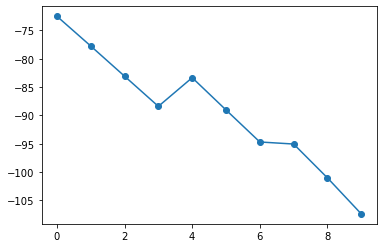

In [25]:
from matplotlib import pyplot as plt
plt.plot(energies_ordered[:,1], '-o')

In [ ]:
# frag_types = ['[GeH3]', '[AsH2]', '[SeH]', 'Br']
# comps = []
# for i in range(len(frag_types)):
#     for j in range(i, len(frag_types)):
#         comps.append(frag_types[i]+ frag_types[j])

In [ ]:
energies_ordered

# Mixed rows

In [ ]:
import glob
import ase.io as aio
from ase.visualize import view
import numpy as np

import re
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

In [ ]:
frags_row_2 = ['C', 'N', 'O', 'F']
frags_row_3 = ['[SiH3]', '[PH2]', '[SH]', 'Cl']
frags_row_4 = ['[GeH3]', '[AsH2]', '[SeH]', 'Br']

row = 'mixed_3_4'
if row ==  'mixed_2_3':
    frags_row_i = frags_row_2
    frags_row_j = frags_row_3
elif row ==  'mixed_2_4':
    frags_row_i = frags_row_2
    frags_row_j = frags_row_4
elif row ==  'mixed_3_4':
    frags_row_i = frags_row_3
    frags_row_j = frags_row_4

smiles = []
for i in frags_row_i:
    for j in frags_row_j:
        smiles.append(i+j)
with open(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/smiles', 'w') as f:
    for e in smiles:
        f.write(e+'\n')

In [ ]:
row = 'mixed_2_3'

paths = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/*.xyz')
for p in paths:
    view(aio.read(p))

# same distance for all atoms

In [ ]:
# identify second group
# set distance second group


In [66]:
import pysmiles as ps
import glob
import ase.io as aio
from ase.visualize import view

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

import numpy as np
from matplotlib import pyplot as plt

In [86]:
# row = 'row_4'
dist = 1.42

xyz_files_new = []

for row in ['row_2', 'row_3', 'row_4']:
    xyz_files = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/diatomics_single/*_opt.xyz')
    smiles = []
    for f in xyz_files:
        s = f.split('/')[-1].split('_')[0]
#         print(s)
        if 'Si' in s:
            s = s.replace('Si', '[SiH3]')
        smiles.append(s)


    for s, f in zip(smiles, xyz_files):
        atoms = aio.read(f)
        num_atoms = atoms.get_global_number_of_atoms()

        graph = ps.read_smiles(s)
        num_h1 = graph.nodes(data='hcount')[1]
        indices = [1] # second heavy atom
        indices.extend(list(range(num_atoms-num_h1, num_atoms))) # hydrogens attached to second heavy atom

        atoms_new = atoms.copy()
        atoms_new.set_distance(0, 1, dist, indices=indices, fix = 0)

        file_new = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/distance/{s}_d{str(dist)}.xyz'
        aio.write(file_new, images=atoms_new)
#         xyz_name.append(f'{s}_d{str(dist)}.xyz')
        xyz_files_new.append(file_new)

with open(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/distance/gnu_para_{dist}', 'w') as fs:
    for line in xyz_files_new:
        name = line.split('/')[-1]
        fs.write(f'python /home/sahre/git_repositories/APDFT/prototyping/atomic_energies/analysis/bonding_trends/singlepoint.py \'{name}\'\n')

In [35]:
# total energy of relaxed fragments
energies_frags = dict()

for row in ['row_2', 'row_3', 'row_4']:
    system = 'fragments'
    bond_type = 'single'

    efiles = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/{system}_{bond_type}/*_energy_relaxed')
    for file in efiles:
        with open(file, 'r') as f:
            smiles = file.split('/')[-1].split('_')[0]
            frags = uqm.fragmentize_smiles(smiles)
            frag_name = frags[0]
    #         if len(re.findall(r"\[.*?\]", smiles)) > 0:
    #             frag_name = re.findall(r"\[.*?\]", smiles)[0]
    #         else:
    #             frag_name = re.sub( r"([A-Z])", r" \1", smiles).split()[0]

            energies_frags[frag_name] = float(f.readline().strip('\n'))

In [87]:
# total energy of diatomics
energies_diatomics = dict()
efiles = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/distance/*{str(dist)}_energy')
for file in efiles:
    with open(file, 'r') as f:
        k = file.split('/')[-1].split('_')[0]
        energies_diatomics[k] = float(f.readline().strip('\n'))

# bfe
bfe = dict()
for smiles in energies_diatomics.keys():
    frags = uqm.fragmentize_smiles(smiles)
    assert len(frags) == 2
    
    bfe[smiles] = energies_diatomics[smiles] - (energies_frags[frags[0]]+energies_frags[frags[1]])

# nuc repulsion for fixed distance and only contribution of heteroatoms
structures = glob.glob(f"/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/distance/*_d{dist}.xyz")
e_nuc = dict()
from ase.units import Bohr
d = dist/Bohr

for s in structures:
    mol = aio.read(s)
    k = s.split('/')[-1].split('_')[0]
    
    fixed = mol.get_atomic_numbers()[0]*mol.get_atomic_numbers()[1]/d
    relaxed = mol.get_atomic_numbers()[0]*mol.get_atomic_numbers()[1]/(mol.get_distance(0, 1)/Bohr)
    e_nuc[k] = [fixed]
# bfe, bfe_el, bfe_nuc 
energies = dict()
for k in bfe.keys():
    bfe_el = bfe[k] - e_nuc[k][0]
    #bfe_elr = bfe[k] - e_nuc[k][1]
    
    energies[k] = [bfe[k], bfe_el, e_nuc[k][0]]
    
# # save data
# path = f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/energies_{bond_type}_dict'
# # uqm.save_obj(energies, path)

comps = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF', '[SiH3][SiH3]', '[SiH3]P', '[SiH3]S', '[SiH3]Cl', 'PP', 'PS', 'PCl', 'SS', 'SCl', 'ClCl', '[GeH3][GeH3]','[GeH3][AsH2]','[GeH3][SeH]','[GeH3]Br','[AsH2][AsH2]','[AsH2][SeH]','[AsH2]Br','[SeH][SeH]','[SeH]Br','BrBr']
# comps = ['[SiH3][SiH3]', '[SiH3]P', '[SiH3]S', '[SiH3]Cl', 'PP', 'PS', 'PCl', 'SS', 'SCl', 'ClCl']
# comps = ['[GeH3][GeH3]','[GeH3][AsH2]','[GeH3][SeH]','[GeH3]Br','[AsH2][AsH2]','[AsH2][SeH]','[AsH2]Br','[SeH][SeH]','[SeH]Br','BrBr']
energies_ordered = []
for c in comps:
    energies_ordered.append(energies[c])
energies_ordered = np.array(energies_ordered)
np.savetxt(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/distance/energies_d{dist}.txt', energies_ordered)

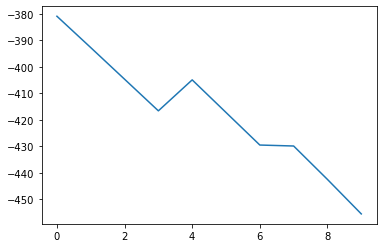

In [88]:
plt.plot(energies_ordered[:,1][20:30])

In [55]:
14**2/d

59.267847583150214

In [ ]:
atoms = ['Si', 'Cl', 'H', 'H', 'H']

In [ ]:
atoms[len(atoms)-num_hydrogens:]

In [ ]:
for f in glob.glob('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/diatomics_single/*d2.xyz'):
    view(aio.read(f))